In [4]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np # ver = 1.22.3
import matplotlib.pyplot as plt
import netCDF4 as nc
import h5py
import sys
import os
from tqdm import tqdm
from datetime import date
from IPython.display import Image
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
%matplotlib inline

In [5]:
os.getcwd()

'/home/jovyan/work'

In [6]:
# assign source directory for retrieving files
path = '/home/jovyan/work'
src_dir = os.path.join(path, 'data')
src_dir

'/home/jovyan/work/data'

In [7]:
# search for source and destination directories. make directories if non-existent
dirs = [src_dir]#, dst_dir]

for dir in dirs:
    if os.path.isdir(dir) == False:
        print(f'Directory {dir} does not exist! Will make.')
        os.mkdir(dir)
        print(f'Directory: {dir} now exists.')
    elif os.path.isdir(dir) == True:
        print(f'Directory: {dir} already exists.')

Directory: /home/jovyan/work/data already exists.


In [8]:
# open .netCDF files in xarray and store in list
datasets = []

for file in os.listdir(src_dir):
    if file.endswith('.nc'):
        try:
            dataset = xr.open_dataset('data/'+file)
            datasets.append(dataset)
        except:
            print(f'{file}: FileNotFoundError')

example_wow_seconds.nc: FileNotFoundError


Per Adrian, can't get the *\_.seconds.nc to upload.

In [9]:
# identify index of each set of data
datasets[0] # hours
datasets[1] # minutes

<xarray.Dataset>
Dimensions:                           (timestamp: 19680, location: 717)
Coordinates:
    lat                               (timestamp, location) float64 ...
  * location                          (location) object '23648819' ... '67c06...
    lon                               (timestamp, location) float64 ...
  * timestamp                         (timestamp) datetime64[ns] 2019-07-30 ....
Data variables: (12/13)
    AirPressure_Hectopascal           (timestamp, location) float64 ...
    DewPointTemperature_Celsius       (timestamp, location) float64 ...
    DryBulbTemperature_Celsius        (timestamp, location) float64 ...
    Height                            (timestamp, location) float64 ...
    MeanSeaLevelPressure_Hectopascal  (timestamp, location) float64 ...
    RainfallAmount_Millimetre         (timestamp, location) float64 ...
    ...                                ...
    RelativeHumidity                  (timestamp, location) float64 ...
    WindDirection                     (timestamp, location) float64 ...
    WindGust_Knot                     (timestamp, location) float64 ...
    WindGust_MetrePerSecond           (timestamp, location) float64 ...
    WindSpeed_Knot                    (timestamp, location) float64 ...
    WindSpeed_MetrePerSecond          (timestamp, location) float64 ...

In [10]:
air_pressure = datasets[1].AirPressure_Hectopascal.to_dataframe()
air_pressure.index

MultiIndex([('2019-07-30 00:00:00',                             '23648819'),
            ('2019-07-30 00:00:00', 'f10d15e0-76ea-e811-a140-0003ff598dc6'),
            ('2019-07-30 00:00:00',                            '923956001'),
            ('2019-07-30 00:00:00', '0cf46235-88a0-e811-b96f-0003ff597c74'),
            ('2019-07-30 00:00:00',                            '900376001'),
            ('2019-07-30 00:00:00', 'f4973f27-9c8f-e811-8c6e-0003ff597a81'),
            ('2019-07-30 00:00:00', 'a556bedb-f295-e911-80e7-0003ff59883f'),
            ('2019-07-30 00:00:00', 'd1084eec-c8b2-e911-b083-0003ff59a71f'),
            ('2019-07-30 00:00:00', '92161a88-5692-e811-b96f-0003ff597c74'),
            ('2019-07-30 00:00:00',                            '961086001'),
            ...
            ('2019-08-29 23:59:00', '9f251d3e-f2fc-e711-90cd-0003ff5993a0'),
            ('2019-08-29 23:59:00', '15f7a59b-0898-e911-80e7-0003ff59883f'),
            ('2019-08-29 23:59:00', 'a3cf2d83-7475-e911-80e7

In [11]:
air_pressure

lat       lon  \
timestamp           location                                                    
2019-07-30 00:00:00 23648819                              51.083000  6.775000   
                    f10d15e0-76ea-e811-a140-0003ff598dc6        NaN       NaN   
                    923956001                                   NaN       NaN   
                    0cf46235-88a0-e811-b96f-0003ff597c74  52.292694  5.598602   
                    900376001                                   NaN       NaN   
...                                                             ...       ...   
2019-08-29 23:59:00 d0f384ae-0d15-e911-9462-0003ff598847        NaN       NaN   
                    085f9b9a-5d79-e711-9401-0003ff59b0cc        NaN       NaN   
                    ce77ae9b-6161-e711-9401-0003ff598dd1        NaN       NaN   
                    916136001                                   NaN       NaN   
                    67c0638e-a7b0-e911-b083-0003ff598cc1        NaN       NaN   

                                                          AirPressure_Hectopascal  
timestamp           location                                                       
2019-07-30 00:00:00 23648819                                                  NaN  
                    f10d15e0-76ea-e811-a140-0003ff598dc6                      NaN  
                    923956001                                                 NaN  
                    0cf46235-88a0-e811-b96f-0003ff597c74                      NaN  
                    900376001                                                 NaN  
...                                                                           ...  
2019-08-29 23:59:00 d0f384ae-0d15-e911-9462-0003ff598847                      NaN  
                    085f9b9a-5d79-e711-9401-0003ff59b0cc                      NaN  
                    ce77ae9b-6161-e711-9401-0003ff598dd1                      NaN  
                    916136001                                                 NaN  
                    67c0638e-a7b0-e911-b083-0003ff598cc1                      NaN  

[14110560 rows x 3 columns]

### **Data Exploration**

In [12]:
# identify max air pressure 
air_pressure['AirPressure_Hectopascal'].max() # 1073.31599355

1073.31599355

In [13]:
# identify min air pressure
air_pressure['AirPressure_Hectopascal'].min()

0.0

Clearly we have some 'bad' air pressure data as air pressure cannot be 0.0!

In [14]:
air_pressure['AirPressure_Hectopascal'].describe().T

count    435018.000000
mean       1014.000514
std           7.588105
min           0.000000
25%        1009.821200
50%        1013.700000
75%        1017.948533
max        1073.315994
Name: AirPressure_Hectopascal, dtype: float64

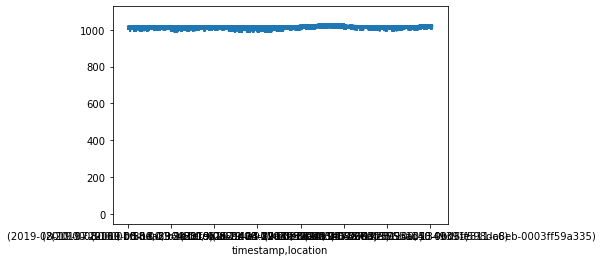

In [15]:
air_pressure['AirPressure_Hectopascal'].plot()
plt.show()

In [16]:
air_pressure['AirPressure_Hectopascal'].value_counts(ascending=True)

1010.201328       1
1012.366337       1
1012.462243       1
1012.634724       1
1012.729584       1
               ... 
1014.562144    7690
1012.191672    7713
1012.530311    7819
1015.239422    8304
1012.868950    9854
Name: AirPressure_Hectopascal, Length: 2937, dtype: int64

### **Data Preparation**

In [17]:
# filter unreasonable (values less than 900 hectopascals) air pressure values
air_pressure = air_pressure[air_pressure['AirPressure_Hectopascal'] >=900]
air_pressure

lat       lon  \
timestamp           location                                                    
2019-07-30 00:00:00 942156001                             53.303520  5.719207   
                    ebccb43b-e33b-e811-a823-0003ff598bf1  50.782100  2.832900   
                    b2036eb6-d504-e811-90cd-000d3ab1c140  52.028323  5.553562   
                    8bb6efd7-519b-e811-b96f-0003ff597c74  51.980437  4.341589   
                    47a0c543-48f9-e811-a140-0003ff5991b2  51.973000  4.450000   
...                                                             ...       ...   
2019-08-29 23:59:00 976856001                             51.402531  5.381415   
                    2c1fdcf0-6cd7-e611-9401-000d3ab1ce9d  52.423112  6.816067   
                    924046001                             51.663483  4.544633   
                    84176367-cd1f-e911-9462-0003ff598847  52.662300  4.783900   
                    919736001                             52.629552  4.717822   

                                                          AirPressure_Hectopascal  
timestamp           location                                                       
2019-07-30 00:00:00 942156001                                         1012.530311  
                    ebccb43b-e33b-e811-a823-0003ff598bf1              1009.482561  
                    b2036eb6-d504-e811-90cd-000d3ab1c140               995.598366  
                    8bb6efd7-519b-e811-b96f-0003ff597c74              1012.868950  
                    47a0c543-48f9-e811-a140-0003ff5991b2              1012.191672  
...                                                                           ...  
2019-08-29 23:59:00 976856001                                         1020.996283  
                    2c1fdcf0-6cd7-e611-9401-000d3ab1ce9d              1018.964450  
                    924046001                                         1023.028117  
                    84176367-cd1f-e911-9462-0003ff598847              1019.980367  
                    919736001                                         1022.600000  

[435012 rows x 3 columns]

We have a multi-index pandas dataframe but we only need the timestamp not the location. Therefore, we will drop the location index and reindex by timestamp. To do so we must indentify the index and convert to pandas datetime object with identified format.

In [18]:
air_pressure = air_pressure.droplevel('location') # drop location index
air_pressure.index = pd.to_datetime(air_pressure.index, format = '%Y-%m-%d %H:%M:%S') # reindex with timestamp

In [19]:
air_pressure

,lat,lon,AirPressure_Hectopascal
timestamp,,,
2019-07-30 00:00:00,53.303520,5.719207,1012.530311
2019-07-30 00:00:00,50.782100,2.832900,1009.482561
2019-07-30 00:00:00,52.028323,5.553562,995.598366
2019-07-30 00:00:00,51.980437,4.341589,1012.868950
2019-07-30 00:00:00,51.973000,4.450000,1012.191672
...,...,...,...
2019-08-29 23:59:00,51.402531,5.381415,1020.996283
2019-08-29 23:59:00,52.423112,6.816067,1018.964450
2019-08-29 23:59:00,51.663483,4.544633,1023.028117


We have a dataframe made up of datetimes, coordinates (lats, lons), and air pressure sorted by date. We need to group the air pressure values by lat and lon (same location). Additionally, we need to resample the data to different temporal resolutions such as 5-min, 10-min, 15-min and 60-min. The final step is to aggregate the data to mean, min and max values. 

### **Group, Resample and Aggregate Air Pressure Data**

In [20]:
# create 5-min value aggregate groupings
air_pressure_5min = air_pressure.groupby(['lat','lon',air_pressure.index.round('5min')]).agg({'AirPressure_Hectopascal':['mean','min','max']})
air_pressure_5min

AirPressure_Hectopascal               \
                                                          mean          min   
lat       lon      timestamp                                                  
50.665725 4.586812 2019-07-30 00:10:00             1016.000000  1016.000000   
                   2019-07-30 00:30:00             1015.800000  1015.800000   
                   2019-07-30 00:40:00             1015.800000  1015.800000   
                   2019-07-30 01:05:00             1015.700000  1015.700000   
                   2019-07-30 01:25:00             1015.600000  1015.600000   
...                                                        ...          ...   
53.380600 5.969800 2019-08-29 23:30:00             1021.267195  1021.267195   
                   2019-08-29 23:35:00             1021.334922  1021.334922   
                   2019-08-29 23:45:00             1021.301059  1021.301059   
                   2019-08-29 23:50:00             1021.301059  1021.301059   
                   2019-08-29 23:55:00             1021.368786  1021.368786   

                                                     
                                                max  
lat       lon      timestamp                         
50.665725 4.586812 2019-07-30 00:10:00  1016.000000  
                   2019-07-30 00:30:00  1015.800000  
                   2019-07-30 00:40:00  1015.800000  
                   2019-07-30 01:05:00  1015.700000  
                   2019-07-30 01:25:00  1015.600000  
...                                             ...  
53.380600 5.969800 2019-08-29 23:30:00  1021.267195  
                   2019-08-29 23:35:00  1021.334922  
                   2019-08-29 23:45:00  1021.301059  
                   2019-08-29 23:50:00  1021.301059  
                   2019-08-29 23:55:00  1021.368786  

[422283 rows x 3 columns]

In [21]:
# create 10-min value aggregate groupings
air_pressure_10min = air_pressure.groupby(['lat','lon',air_pressure.index.round('10min')]).agg({'AirPressure_Hectopascal':['mean','min','max']})
air_pressure_10min

AirPressure_Hectopascal               \
                                                          mean          min   
lat       lon      timestamp                                                  
50.665725 4.586812 2019-07-30 00:10:00             1016.000000  1016.000000   
                   2019-07-30 00:30:00             1015.800000  1015.800000   
                   2019-07-30 00:40:00             1015.800000  1015.800000   
                   2019-07-30 01:10:00             1015.700000  1015.700000   
                   2019-07-30 01:30:00             1015.600000  1015.600000   
...                                                        ...          ...   
53.380600 5.969800 2019-08-29 23:10:00             1021.301059  1021.301059   
                   2019-08-29 23:20:00             1021.334922  1021.334922   
                   2019-08-29 23:30:00             1021.317990  1021.267195   
                   2019-08-29 23:40:00             1021.317990  1021.301059   
                   2019-08-29 23:50:00             1021.334922  1021.301059   

                                                     
                                                max  
lat       lon      timestamp                         
50.665725 4.586812 2019-07-30 00:10:00  1016.000000  
                   2019-07-30 00:30:00  1015.800000  
                   2019-07-30 00:40:00  1015.800000  
                   2019-07-30 01:10:00  1015.700000  
                   2019-07-30 01:30:00  1015.600000  
...                                             ...  
53.380600 5.969800 2019-08-29 23:10:00  1021.301059  
                   2019-08-29 23:20:00  1021.334922  
                   2019-08-29 23:30:00  1021.368786  
                   2019-08-29 23:40:00  1021.334922  
                   2019-08-29 23:50:00  1021.368786  

[286519 rows x 3 columns]

In [22]:
# create 15-min value aggregate groupings
air_pressure_15min = air_pressure.groupby(['lat','lon',air_pressure.index.round('15min')]).agg({'AirPressure_Hectopascal':['mean','min','max']})
air_pressure_15min

AirPressure_Hectopascal               \
                                                          mean          min   
lat       lon      timestamp                                                  
50.665725 4.586812 2019-07-30 00:15:00             1016.000000  1016.000000   
                   2019-07-30 00:30:00             1015.800000  1015.800000   
                   2019-07-30 00:45:00             1015.800000  1015.800000   
                   2019-07-30 01:00:00             1015.700000  1015.700000   
                   2019-07-30 01:30:00             1015.600000  1015.600000   
...                                                        ...          ...   
53.380600 5.969800 2019-08-29 23:00:00             1021.250263  1021.233331   
                   2019-08-29 23:15:00             1021.323634  1021.301059   
                   2019-08-29 23:30:00             1021.323634  1021.267195   
                   2019-08-29 23:45:00             1021.301059  1021.301059   
                   2019-08-30 00:00:00             1021.368786  1021.368786   

                                                     
                                                max  
lat       lon      timestamp                         
50.665725 4.586812 2019-07-30 00:15:00  1016.000000  
                   2019-07-30 00:30:00  1015.800000  
                   2019-07-30 00:45:00  1015.800000  
                   2019-07-30 01:00:00  1015.700000  
                   2019-07-30 01:30:00  1015.600000  
...                                             ...  
53.380600 5.969800 2019-08-29 23:00:00  1021.267195  
                   2019-08-29 23:15:00  1021.334922  
                   2019-08-29 23:30:00  1021.368786  
                   2019-08-29 23:45:00  1021.301059  
                   2019-08-30 00:00:00  1021.368786  

[214506 rows x 3 columns]

In [23]:
# create 60-min value aggregate groupings
air_pressure_60min = air_pressure.groupby(['lat','lon',air_pressure.index.round('60min')]).agg({'AirPressure_Hectopascal':['mean','min','max']})
air_pressure_60min

AirPressure_Hectopascal               \
                                                          mean          min   
lat       lon      timestamp                                                  
50.665725 4.586812 2019-07-30 00:00:00             1015.900000  1015.800000   
                   2019-07-30 01:00:00             1015.700000  1015.600000   
                   2019-07-30 02:00:00             1015.600000  1015.600000   
                   2019-07-30 03:00:00             1015.350000  1015.300000   
                   2019-07-30 04:00:00             1015.266667  1015.200000   
...                                                        ...          ...   
53.380600 5.969800 2019-08-29 20:00:00             1020.657645  1020.556053   
                   2019-08-29 21:00:00             1020.851592  1020.725372   
                   2019-08-29 22:00:00             1021.184074  1021.097875   
                   2019-08-29 23:00:00             1021.267195  1021.165603   
                   2019-08-30 00:00:00             1021.314604  1021.267195   

                                                     
                                                max  
lat       lon      timestamp                         
50.665725 4.586812 2019-07-30 00:00:00  1016.000000  
                   2019-07-30 01:00:00  1015.800000  
                   2019-07-30 02:00:00  1015.600000  
                   2019-07-30 03:00:00  1015.400000  
                   2019-07-30 04:00:00  1015.300000  
...                                             ...  
53.380600 5.969800 2019-08-29 20:00:00  1020.793100  
                   2019-08-29 21:00:00  1021.064011  
                   2019-08-29 22:00:00  1021.267195  
                   2019-08-29 23:00:00  1021.368786  
                   2019-08-30 00:00:00  1021.368786  

[57767 rows x 3 columns]

In [24]:
# # pull out data for one time stamp to test spatial intepolation
test_interpol = air_pressure_60min.query('timestamp==\'2019-07-30 01:00:00\'')
test_interpol

AirPressure_Hectopascal               \
                                                          mean          min   
lat       lon      timestamp                                                  
50.665725 4.586812 2019-07-30 01:00:00             1015.700000  1015.600000   
50.704492 3.136128 2019-07-30 01:00:00             1007.450727  1007.450727   
50.727963 2.913576 2019-07-30 01:00:00             1006.948413  1006.130036   
50.782100 2.832900 2019-07-30 01:00:00             1009.482561  1009.482561   
50.794600 5.922100 2019-07-30 01:00:00             1011.699106  1011.514394   
...                                                        ...          ...   
53.303520 5.719207 2019-07-30 01:00:00             1012.360992  1012.191672   
53.322532 6.859426 2019-07-30 01:00:00             1013.743767  1013.546228   
53.337542 6.531484 2019-07-30 01:00:00             1012.686606  1012.530311   
53.362600 6.462600 2019-07-30 01:00:00             1013.823296  1013.546228   
53.380600 5.969800 2019-07-30 01:00:00             1011.805624  1011.751442   

                                                     
                                                max  
lat       lon      timestamp                         
50.665725 4.586812 2019-07-30 01:00:00  1015.800000  
50.704492 3.136128 2019-07-30 01:00:00  1007.450727  
50.727963 2.913576 2019-07-30 01:00:00  1007.112089  
50.782100 2.832900 2019-07-30 01:00:00  1009.482561  
50.794600 5.922100 2019-07-30 01:00:00  1011.920761  
...                                             ...  
53.303520 5.719207 2019-07-30 01:00:00  1012.530311  
53.322532 6.859426 2019-07-30 01:00:00  1013.884867  
53.337542 6.531484 2019-07-30 01:00:00  1012.868950  
53.362600 6.462600 2019-07-30 01:00:00  1014.223505  
53.380600 5.969800 2019-07-30 01:00:00  1011.853033  

[173 rows x 3 columns]

In [25]:
# check for null values
test_interpol.isnull().sum()

AirPressure_Hectopascal  mean    0
                         min     0
                         max     0
dtype: int64

No NaN values detected so no need to perform dropna operation

### **Test Interpolation on Specified Number of Samples (n)**

Since length of test_interpol is 173, must choose an 'n' value equal to or less than 173.

In [26]:
test_interpol_sample = test_interpol.sample(n=150)
test_interpol_sample

AirPressure_Hectopascal               \
                                                          mean          min   
lat       lon      timestamp                                                  
51.636839 4.481797 2019-07-30 01:00:00             1010.554917  1010.498478   
52.502789 4.832029 2019-07-30 01:00:00             1010.904844  1010.837116   
52.470470 4.749672 2019-07-30 01:00:00             1012.157808  1011.853033   
53.085891 5.833441 2019-07-30 01:00:00             1011.457954  1011.175755   
52.846800 4.759600 2019-07-30 01:00:00             1013.546228  1013.546228   
...                                                        ...          ...   
51.029807 4.136161 2019-07-30 01:00:00             1010.098268  1009.821200   
52.779678 6.798021 2019-07-30 01:00:00             1011.264648  1011.175755   
52.787700 6.939000 2019-07-30 01:00:00             1011.886897  1011.886897   
52.085314 4.896198 2019-07-30 01:00:00             1012.530311  1012.530311   
51.631464 5.552427 2019-07-30 01:00:00             1007.724359  1007.624224   

                                                     
                                                max  
lat       lon      timestamp                         
51.636839 4.481797 2019-07-30 01:00:00  1010.837116  
52.502789 4.832029 2019-07-30 01:00:00  1011.175755  
52.470470 4.749672 2019-07-30 01:00:00  1012.191672  
53.085891 5.833441 2019-07-30 01:00:00  1011.514394  
52.846800 4.759600 2019-07-30 01:00:00  1013.546228  
...                                             ...  
51.029807 4.136161 2019-07-30 01:00:00  1010.159839  
52.779678 6.798021 2019-07-30 01:00:00  1011.345075  
52.787700 6.939000 2019-07-30 01:00:00  1011.886897  
52.085314 4.896198 2019-07-30 01:00:00  1012.530311  
51.631464 5.552427 2019-07-30 01:00:00  1007.824137  

[150 rows x 3 columns]

In [27]:
# extract lat and lons from index
lats=test_interpol_sample.index.get_level_values('lat') # must use get_level_values because multi-index df
lons=test_interpol_sample.index.get_level_values('lon')

In [28]:
print(f'Number of latitudes = {len(lats)}{os.linesep}Number of longitudes = {len(lons)}')

Number of latitudes = 150
Number of longitudes = 150


### **Define a Bounding Box for Netherlands**

In [29]:
xmin=3 # longitude; western extent of country
ymin=50.719069 # latitude; southern extent of country
xmax=7.316895 # longitude; eastern extent of country
ymax=54 # latitude; nothern extent of country

In [30]:
# make a 100 x 100 grid inside bounding box extents
grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)

In [32]:
NL_Boundary_Shapefile = './NL_shapefile/NL_shapefile.shp'
boundary = gpd.read_file(NL_Boundary_Shapefile)
boundary

,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_na,class,type,importance,geometry
0,53.744395,50.750366,7.227499,3.080161,285360560,relation,12728888,52.24765,5.541247,"European Netherlands, Netherlands",place,region,0.37084,"MULTIPOLYGON (((3.08016 51.55078, 3.08052 51.5..."


In [33]:
zdata = test_interpol_sample.AirPressure_Hectopascal
zdata

,,,mean,min,max
lat,lon,timestamp,,,
51.636839,4.481797,2019-07-30 01:00:00,1010.554917,1010.498478,1010.837116
52.502789,4.832029,2019-07-30 01:00:00,1010.904844,1010.837116,1011.175755
52.470470,4.749672,2019-07-30 01:00:00,1012.157808,1011.853033,1012.191672
53.085891,5.833441,2019-07-30 01:00:00,1011.457954,1011.175755,1011.514394
52.846800,4.759600,2019-07-30 01:00:00,1013.546228,1013.546228,1013.546228
...,...,...,...,...,...
51.029807,4.136161,2019-07-30 01:00:00,1010.098268,1009.821200,1010.159839
52.779678,6.798021,2019-07-30 01:00:00,1011.264648,1011.175755,1011.345075
52.787700,6.939000,2019-07-30 01:00:00,1011.886897,1011.886897,1011.886897


In [34]:
zdata = zdata['mean'].to_numpy()
zdata

array([1010.55491742, 1010.90484428, 1012.15780821, 1011.45795448,
       1013.5462277 , 1009.76666667, 1011.19114808, 1011.60469801,
       1011.5143943 , 1010.8371165 , 1011.1757554 , 1011.1757554 ,
       1011.1757554 , 1010.25219476, 1011.68371375, 1009.90585952,
       1011.8530332 , 1009.4825609 , 1011.28966121, 1013.8848666 ,
       1012.69963045, 1011.94978717, 1010.91236959, 1014.5621444 ,
       1011.90947302, 1010.1598387 , 1013.57701305, 1013.45387164,
       1009.39790117, 1010.        , 1011.91460391, 1011.66832107,
       1010.66779705, 1011.37329476, 1018.6258112 , 1011.96591283,
       1011.10802762, 1012.36099155, 1013.5462277 , 1012.15442182,
       1011.54261421, 1012.63805974, 1011.28863503, 1011.8530332 ,
       1011.56277129, 1009.57491696, 1009.65188035, 1011.28863503,
       1011.28863503, 1013.3       , 1011.8530332 , 1010.82865053,
       1011.54517965, 1007.56360713, 1012.08333333, 1009.00846644,
       1012.16345219, 1004.08588825, 1006.60105171, 1010.17112

In [35]:
# initialize variogram model
Ordinary_Kriging = OrdinaryKriging(lons, lats, zdata, variogram_model='linear', verbose=True, enable_plotting=False,nlags=20)
Ordinary_Kriging

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 1.4541431531950955
Nugget: 5.559996440399715 

Calculating statistics on variogram model fit...


In [38]:
# compute statistics
z2, ss1 = Ordinary_Kriging.execute('grid', grid_lon, grid_lat)

Executing Ordinary Kriging...

[[1008.1471249348493 1008.1949568163035 1008.2570894301294 ...
  1010.8885975657597 1010.890948001306 1010.8931670306295]
 [1008.1340382087839 1008.1851667746186 1008.2554130783981 ...
  1010.9019178722933 1010.9038739782234 1010.9057215444492]
 [1008.121736292594 1008.177226428327 1008.2576235566081 ...
  1010.9151285188517 1010.9166791706789 1010.9181470464113]
 ...
 [1010.7682535956302 1010.7927471664573 1010.8173451464786 ...
  1012.0384241721264 1012.0258842892765 1012.0135421335498]
 [1010.7777065053175 1010.8020040367262 1010.8264020264568 ...
  1012.0451560725512 1012.0331005679094 1012.0211910739193]
 [1010.7870017422397 1010.8111054479011 1010.8353057840701 ...
  1012.0513586752936 1012.0397758931219 1012.0282935804763]]


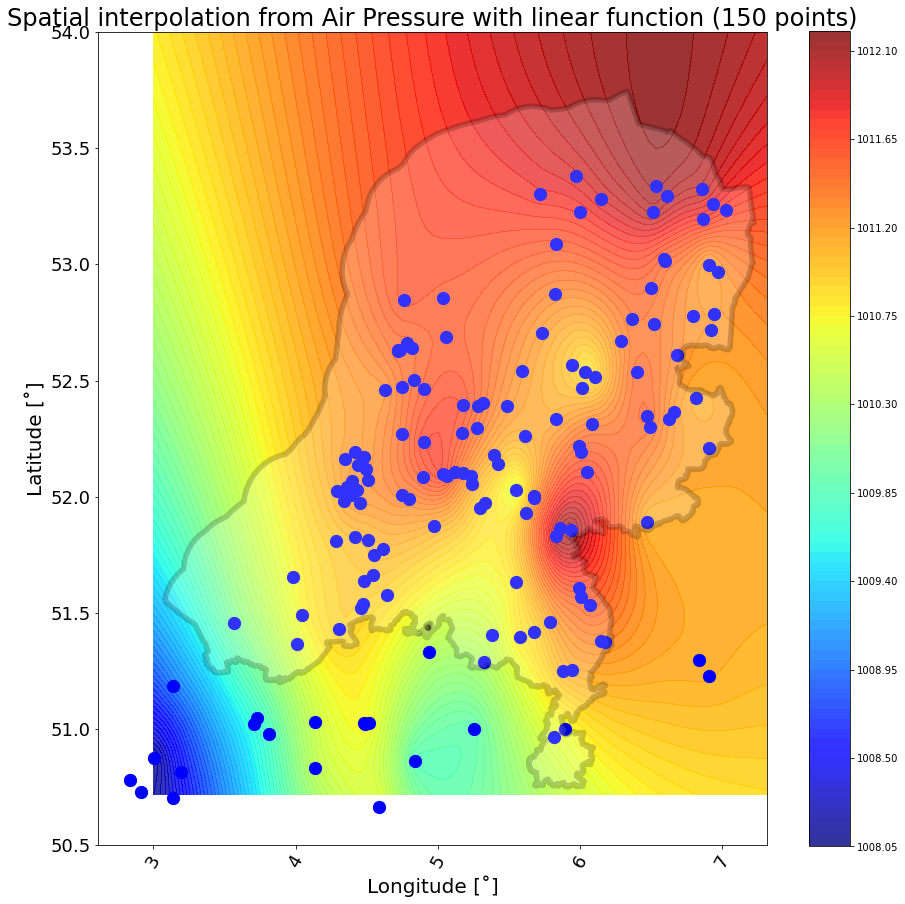

In [55]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(15,15))

#ax.scatter(lons, lats, s=len(lons), label='Input data')
boundarygeom = boundary.geometry

contour = plt.contourf(xintrp, yintrp, z2,len(z2),cmap=plt.cm.jet,alpha = 0.8) 

plt.colorbar(contour)

boundary.plot(ax=ax, color='white', alpha = 0.2, linewidth=5.5, edgecolor='black', zorder = 5)

npts = len(lons)

plt.scatter(lons, lats,marker='o',c='b',s=npts)

plt.xlabel('Longitude [˚]', fontsize = 20)
plt.ylabel('Latitude [˚]', fontsize = 20)
plt.xticks(fontsize = 18, rotation=60)
plt.yticks(fontsize = 18)

# Air Pressure
plt.title('Spatial interpolation from Air Pressure with linear function (%d points)' % npts,fontsize = 24)
plt.savefig('AirPressure_Kriging.png')
plt.show()


WOW-NL stations monitor (and report?) accumulated precipitation data throughout day, continuous observations, 5, 6, 7 rain and report at 9 contains sum of rain at 5, 6, 7

NetAtmo stations report rain observed w/in a time interval and clocks reset at midnight

Challenge: disagreement between data about time of observation

Solution: path time-series from WOW-NL to match NetAtmo data*

* Irene's script has two 


In [ ]:
# from irene's patching script

# Now we clean implausible values from the 'values' column
df["five_min_rainfall"] = df["five_min_rainfall"].fillna(0)
df["five_min_rainfall"][df["five_min_rainfall"] < 0] = 0
df["five_min_rainfall"][df["five_min_rainfall"] > 80] = 80